# Learning a Stationary Distribution

First, let's install **nflows**, which we will use to build our normalizing flows: https://github.com/bayesiains/nflows

Throughout, we will utilize the *neural spline flow* architecture: https://arxiv.org/pdf/1906.04032.pdf

Some of the code chunks for defining the flow architecture and training loops also come from: https://github.com/bayesiains/nsf



In [ ]:
!pip install nflows 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 1.4 MB/s 
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53671 sha256=1eaf2ab609316c3e67d535c0eacbfc95ab9e644e8ff7365c9b1cdb7c847988be
  Stored in directory: /root/.cache/pip/wheels/c0/b6/52/0092eedabce8f7faa35b92522393fbdc1ec5ede99b0ec820d5
Successfully built nflows


Now, let's import the rest of the modules and packages we will need.


In [ ]:
from nflows import transforms, distributions, flows
from nflows.nn.nets.resnet import ResidualNet
from nflows.nn.nets.mlp import MLP
from nflows.flows.base import Flow
from nflows.utils import create_alternating_binary_mask,get_num_parameters,tensor2numpy
import numpy as np
import torch
from torch import optim
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import datasets
import torch
import random

Before we model time-dependent densities, let's take a quick look at a stationary distribution. We will begin by approximating the density of the "moons" data set. For starters, let's look at some samples.

(-1.25, 1.5)

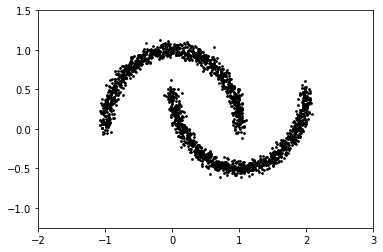

In [ ]:
Data,_ = datasets.make_moons(n_samples=2000, shuffle=True, noise=.05, random_state=None)
_,dim = np.shape(Data)
plt.scatter(Data[:,0],Data[:,1],c = 'k',s = 3)
plt.xlim(-2,3)
plt.ylim(-1.25,1.5)

Now, let's build the flow architecture and base distribution. Here we will use a flow which comprises of two spline-based coupling layers. 

In [ ]:
def create_base_transform(i):
            return transforms.PiecewiseRationalQuadraticCouplingTransform(
                mask=create_alternating_binary_mask(features=dim, even=(i % 2 == 0)),
                transform_net_create_fn=lambda in_features, out_features: ResidualNet(
                    in_features=in_features,
                    out_features=out_features,
                    hidden_features=128,
                    context_features = 0,
                    num_blocks=2,
                    use_batch_norm=True
                ),
                tails='linear',
                tail_bound=3,
                num_bins=8,
                apply_unconditional_transform=False
            )
    
transform = transforms.CompositeTransform([create_base_transform(i) for i in range(2)])
distribution = distributions.StandardNormal((dim,))
flow = Flow(transform, distribution)

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Let's now train our flow for 100 steps. To do this, we first set the learning rate and batch size. These hyper-parameters control how quickly the flow attempts to learn and the number of samples it trains on before updating the weights of the network. 

In [ ]:
learning_rate = 1e-3
batch_size = 100
steps = 100
optimizer = optim.Adam(flow.parameters(), lr=learning_rate)

def train():
        tbar = tqdm(range(steps))
        for step in tbar:
            batch_samples,_ = datasets.make_moons(n_samples=batch_size, shuffle=True, noise=.05, random_state=None)
            batch_samples = torch.tensor(batch_samples,dtype = torch.float)
            flow.train()
            optimizer.zero_grad()
            log_density = flow.log_prob(batch_samples)
            loss = - torch.mean(log_density)
            loss.backward()
            optimizer.step()
            s = 'Loss: {:.4f}'.format(loss.item())
            tbar.set_description(s)   
        return 

train()

Loss: 0.5046: 100%|██████████| 100/100 [00:01<00:00, 53.93it/s]


Now, we will draw a sample from our flow to see if it did a good job learning the moons distribution.



(-1.25, 1.5)

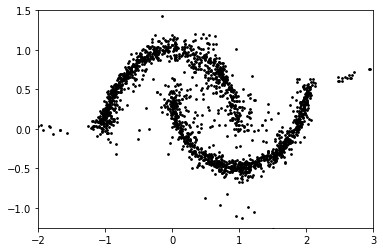

In [ ]:
flow.eval()
with torch.no_grad():
    samples = np.array(tensor2numpy(flow.sample(int(2000))))

plt.scatter(samples[:,0],samples[:,1],c = 'k', s= 3)
plt.xlim(-2,3)
plt.ylim(-1.25,1.5)

Looks pretty good for only 100 training steps! Now let's move onto modeling time-varying densities.


# Learning Time-Varying Densities

We will begin by generating our time-dependent data. Specifically, we will use the Euler-Maruyama method to generate an ensemble of SDE sample paths of the 10-dimensional Lorenz-96 system.

In [ ]:
d = 10 #dimension
F = -1.25 #forcing parameter
Tmax = 5 #end time
diffusion = .2 #diffusion
start = -2 #initial condition
Ntimes = 100 #number of times
Npts = 1000 #number of sample paths
dt = Tmax/Ntimes #timestep
        
def L96(x,F):
    S = np.zeros(d)
    for i in range(d):
        S[i] = (x[(i + 1) % d] - x[i - 2]) * x[i - 1] - x[i] + F
    return S
  
def sample_path():
        x = start+diffusion*np.random.normal(0,1,(d)) #initial conditions
        W = diffusion*np.random.normal(0,1,(Ntimes,d)) #brownian motion for euler-maruyama
        X = np.zeros((Ntimes,d))
        t = 0
        ts = []
        for i in range(Ntimes):
            ts.append(t)
            x = x + L96(x,F)*dt+W[i,:]*np.sqrt(dt)
            X[i,:] = x
            t += dt
        return X, ts   

Xs = []
for i in range(Npts):
    X,T = sample_path()
    Xs.append(X)      

m = np.max(np.abs(Xs))
Xs = Xs/m 
Xs = np.array(Xs) 
T = np.array(T)

Let's now look at the data we generated. We will plot the ensemble of sample paths as a 2D histogram to illustrate the distribution of the interacting variables at each timestep. 

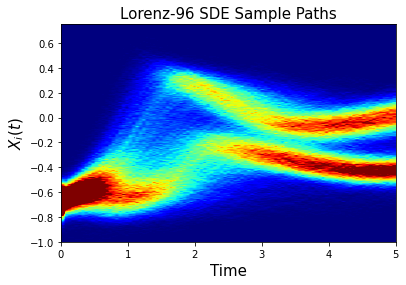

In [ ]:
def plot_SDE(Xs,T):
  TT = np.array(np.tile(T,d*Npts)).reshape(Npts,len(T),d,order = 'F').T.flatten(order = 'C')
  pts = np.zeros((len(TT),2))
  pts[:,0] = TT     
  pts[:,1] = Xs.reshape(Npts,d*len(T),order = 'F').flatten(order = 'C')
  pts = np.array(pts)
  plt.title('Lorenz-96 SDE Sample Paths',fontsize = 15)
  plt.xlabel('Time',fontsize = 15)
  plt.ylabel('$X_i(t)$',fontsize = 15)    
  bounds = [[0,5],[-1,.75]]
  extent = (bounds[0][0],bounds[0][1], bounds[1][0], bounds[1][1])
  P, edges = np.histogramdd(pts, range = bounds, bins = [Ntimes-1,2000],normed=True)
  plt.imshow(P.T,cmap = 'jet',origin = 'lower',vmax = .5,aspect = 'auto',extent = extent)
  plt.show()   

plot_SDE(Xs,T)

Now, let's build the architecture for our conditional flow. This is going to be nearly the same as before, except we now utilize an *embedding network* to encode the time. We must also switch the number of *context features* to 1. 

In [ ]:
def create_base_transform(i):
            return transforms.PiecewiseRationalQuadraticCouplingTransform(
                mask=create_alternating_binary_mask(features=d, even=(i % 2 == 0)),
                transform_net_create_fn=lambda in_features, out_features: ResidualNet(
                    in_features=in_features,
                    out_features=out_features,
                    hidden_features=128,
                    context_features = 1,
                    num_blocks=2,
                    use_batch_norm=True
                ),
                tails='linear',
                tail_bound=3,
                num_bins=8,
                apply_unconditional_transform=False
            )
    
embedding_net = MLP(
        in_shape=[1],
        out_shape=[1],
        hidden_sizes=[100,100],
        activation=torch.nn.ReLU(),
        activate_output=False)

transform = transforms.CompositeTransform([create_base_transform(i) for i in range(2)])
distribution = distributions.StandardNormal((d,))
flow = Flow(transform, distribution,embedding_net)

We are almost ready to train the conditional flow! First, let's just make a simple data loader so that we can sample random subsets of our SDE sample paths. This will be important for the batch training of the flow.

In [ ]:
def load_data_random(trainingsamples,T,numpts): 
    N,tnum,pp = np.shape(trainingsamples)
    r = np.array(random.sample(range(tnum),numpts))
    s = np.array(random.sample(range(N),numpts))
    return trainingsamples[s,r,:], T[r]

We are now ready to train the flow. We will retain roughly the same hyperparameters as before for simplicity. Let's see how it does after 500 steps of training.

In [ ]:
learning_rate = 1e-3
batch_size = 100
steps = 1000
optimizer = optim.Adam(flow.parameters(), lr=learning_rate)

def train():
        tbar = tqdm(range(steps))
        for step in tbar:
            batch_samples, cond_time = load_data_random(Xs,T,batch_size)   
            batch_samples = torch.tensor(batch_samples,dtype = torch.float)
            cond_time = torch.tensor(cond_time, dtype = torch.float).reshape(batch_size,1)
            flow.train()
            optimizer.zero_grad()
            log_density = flow.log_prob(batch_samples,context = cond_time)
            loss = - torch.mean(log_density)
            loss.backward()
            optimizer.step()
            s = 'Loss: {:.4f}'.format(loss.item())
            tbar.set_description(s)   
        return 

train()

Loss: -9.7466: 100%|██████████| 1000/1000 [00:20<00:00, 49.18it/s]


Let's take a look at the flow's samples after 1000 iterations.

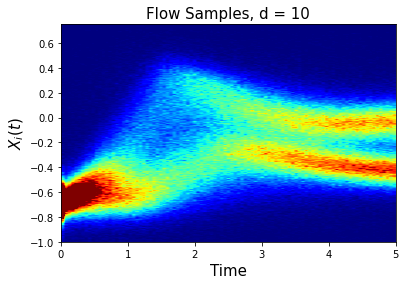

In [ ]:
flow.eval()
with torch.no_grad():
  samples = np.array(tensor2numpy(flow.sample(int(Npts), context = torch.tensor(T,dtype = torch.float).reshape(len(T),1))))

  pts = []
  l = len(T)

  TT = np.array(np.tile(T,d*Npts))
  pts = np.zeros((len(TT),2))
  pts[:,0] = TT
  pts[:,1] = samples.flatten(order = 'F')            
  pts = np.array(pts)

  pts = np.array(pts)
  pts = pts.reshape(len(pts),2)
  plt.title('Flow Samples, d = {}'.format(d),fontsize = 15)
  plt.xlabel('Time',fontsize = 15)
  plt.ylabel('$X_i(t)$',fontsize = 15)    
  bds = [[0,5],[-1,.75]]
  extent = (bds[0][0],bds[0][1], bds[1][0], bds[1][1])
  P, edges = np.histogramdd(pts, range = bds, bins = [len(T)-1,2000],normed=True)
  plt.imshow(P.T,cmap = 'jet',origin = 'lower',vmax = .5,aspect = 'auto',extent = extent)
  plt.show()   

Not bad! With more training time, and possibly a more intricate flow architecture (the original Neural Spline Flows paper uses 10 steps of alternating spline and linear layers) we can expect to see the learned samples converge closely to the correct underlying density. 